In [1]:
from PIL import Image, ImageDraw
from IPython.display import display
import numpy as np
import cv2

import os
import math
import random
import time

import torch # pytorch의 tensor와 그와 관련된 기본 연산 등을 지원
import torch.nn as nn # 여러 딥러닝 layer와 loss, 함수 등을 클래스 형태로 지원
import torch.nn.functional as F # 여러 loss, 함수 등을 function 형태로 지원
import torch.optim as optim # 여러 optimizer를 지원
from torch.utils.data import DataLoader # 데이터 로더를 쉽게 만들 수 있도록 지원

import torchvision.transforms as T # 이미지 전처리를 지원
import torchvision.transforms.functional as TF
import torchvision.utils # 여러가지 편리한 기능을 지원 (ex. grid 이미지 만들기 등)
import torchvision.models as models # VGG, ResNet 등을 바로 로드할 수 있도록 지원
from torchvision.datasets import ImageFolder # (img, label) 형태의 데이터셋 구성을 쉽게 할 수 있도록 지원

# GPU 선택
os.environ['CUDA_VISIBLE_DEVICES']='1'

# GPU가 있을 경우 연산을 GPU에서 하고 없을 경우 CPU에서 진행
#dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev = 'cpu'

In [2]:
class ArcMarginProduct(nn.Module):
    '''
    목적 : Arc marin 을 포함한 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension
    out_features : class 개수
    '''
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        # fc의 parameter 만들기
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        '''
        Step 1. cos(theta + m) 계산하기
        '''
        # cosine : cos(theta)        
        # linear(x, W) = x * W^T = [N, in_features] * [in_features, out_features] = [N, out_features]
        # [N, out_features] / normalize-> cos dist == cos
        # F.normalize는 디폴트가 dim = 1 (줄이고자하는 dimension)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        # c^2 + s^2 = 1 
        sine = torch.sqrt((1.00000001 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # cos(theta + m) = cos(theta) * cos(m) - sin(theta) * sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        '''
        Step 2. cos(theta + m) 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cosine.size()).to(dev)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        '''
        Step 3. 이 output이 softmax -> cross entropy loss로 흘러가면 된다.
        '''
        return output

class FeatureNet_50(nn.Module):
    '''
    목적 : ResNet-50을 이용한 backbone network(feature extractor) 구현 
    
    인자 :
    feature_dim : feature의 dimension
    gray_scale : 이미지를 gray scale로 받았는지 여부
    '''
    def __init__(self, feature_dim, gray_scale=True):
        super(FeatureNet_50, self).__init__()
        # Pytorch에서 이미 구현되어 있는 resnet-50 불러오기
        resnet = models.resnet50(pretrained=True)
        
        # 이런식으로 불러온 resnet을 조건에 맞게 변경할 수 있다.
        if gray_scale:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
        # resnet의 마지막 conv block까지만 남기고 나머지 부분 잘라내기
        self.backbone = nn.Sequential(* list(resnet.children())[0:-2])
        
        # resnet의 마지막 conv block 뒤쪽으로 새로 붙을 layer 들
        self.bn_4 = nn.BatchNorm2d(2048)
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048 * 4 * 4, feature_dim)
        self.bn_5 = nn.BatchNorm1d(feature_dim)
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.bn_4(out)
        out = self.dropout(out)
        
        # FC layer를 지나기 전에는 reshape 과정이 필요하다.
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.bn_5(out)
        return out

class ArcFaceNet(nn.Module):
    '''
    ArcMarginProduct와 FeatureNet-50 을 결합한 ArcFace 모델의 구현
    '''
    def __init__(self, feature_dim, cls_num, gray_scale=True):
        super(ArcFaceNet, self).__init__()
        self.feature_net = FeatureNet_50(feature_dim, gray_scale=gray_scale)
        self.classifier = ArcMarginProduct(feature_dim, cls_num)

    # 끝까지 Forward 하여 logit을 return
    def forward(self, x, label):
        out = self.feature_net(x)
        out = self.classifier(out, label)
        return out
    
    # Feature만 return
    def extract_feature(self, x):
        out = self.feature_net(x)
        return out


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import numpy as np
from collections import OrderedDict
from PIL import Image, ImageDraw, ImageFont

from box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, _preprocess

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        # without this pretrained model isn't working
        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class PNet(nn.Module):
    def __init__(self):
        super(PNet, self).__init__()
        # suppose we have input with size HxW, then
        # after first layer: H - 2,
        # after pool: ceil((H - 2)/2),
        # after second conv: ceil((H - 2)/2) - 2,
        # after last conv: ceil((H - 2)/2) - 4,
        # and the same for W

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('weights/pnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4, h', w'].
            a: a float tensor with shape [batch_size, 2, h', w'].
        """
        x = self.features(x)
        a = self.conv4_1(x)
        b = self.conv4_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a


class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('weights/rnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv5_1(x)
        b = self.conv5_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a


class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('weights/onet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            c: a float tensor with shape [batch_size, 10].
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv6_1(x)
        b = self.conv6_2(x) # Bounding Box Regression
        c = self.conv6_3(x) # Face Landmark Detection
        a = F.softmax(a, dim=1) # Face Classification
        return c, b, a


def run_first_stage(image, net, scale, threshold):
    """Run P-Net, generate bounding boxes, and do NMS.

    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.

    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    width, height = image.size
    sw, sh = math.ceil(width*scale), math.ceil(height*scale)
    img = image.resize((int(sw), int(sh)), Image.BILINEAR)
    img = np.asarray(img, 'float32')

    with torch.no_grad():
        img = Variable(torch.FloatTensor(_preprocess(img)))
#         if torch.cuda.is_available():
#             img = img.cuda()
#             net = net.cuda()
        img=img.cpu()
        net=net.cpu()
    output = net(img)
    probs = output[1].data.cpu().numpy()[0, 1, :, :]
    offsets = output[0].data.cpu().numpy()
    # probs: probability of a face at each sliding window
    # offsets: transformations to true bounding boxes

    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.

    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.

    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T


def detect_faces(image, min_face_size=20.0,
                 thresholds=[0.6, 0.7, 0.8],
                 nms_thresholds=[0.7, 0.7, 0.7]):
    """
    Arguments:
        image: an instance of PIL.Image.
        min_face_size: a float number.
        thresholds: a list of length 3.
        nms_thresholds: a list of length 3.

    Returns:
        two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
        bounding boxes and facial landmarks.
    """

    # LOAD MODELS
    pnet = PNet()
    rnet = RNet()
    onet = ONet()
    onet.eval()

    # BUILD AN IMAGE PYRAMID
    width, height = image.size
    min_length = min(height, width)

    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
    m = min_detection_size/min_face_size
    min_length *= m

    factor_count = 0
    # scales = [0.6, 0.42, 0.30, 0.21, 0.15, 0.10, 0.07, 0.05, 0.03]
    while min_length > min_detection_size:
        scales.append(m*factor**factor_count)
        min_length *= factor
        factor_count += 1

    # STAGE 1

    # it will be returned
    bounding_boxes = []

    # run P-Net on different scales
    for s in scales:
        boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)

    # collect boxes (and offsets, and scores) from different scales
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    # shape [n_boxes, 5]

    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 2

    img_boxes = get_image_boxes(bounding_boxes, image, size=24)
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            rnet = rnet.cuda()
            img_boxes = img_boxes.cuda()
    output = rnet(img_boxes)
    offsets = output[0].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[1].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 3

    img_boxes = get_image_boxes(bounding_boxes, image, size=48)
    if len(img_boxes) == 0:
        return [], []
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            onet = onet.cuda()
            img_boxes = img_boxes.cuda()
    output = onet(img_boxes)
    landmarks = output[0].data.cpu().numpy()  # shape [n_boxes, 10]
    offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[2].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
    landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='min') # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]

    return bounding_boxes, landmarks


def show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.

    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].

    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)

    # Draw Bounding boxes
    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    # Draw Facial Landmarks
    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='blue')

    return img_copy


In [4]:
# 각종 경로
trn_data_dir = './data/CASIA-WebFace'
tst_data_dir = './data/lfw'
lfw_pair_text = 'lfw_test_part.txt'
log_dir = 'log/arcface'
weight_dir = 'weight/arcface'

# 데이터 관련 세팅
batch_size = 16
resize = 128
crop = 128
cls_num=10575
gray_scale = True

# Hyperparameter
feature_dim = 512
lr = 0.1  # initial learning rate
lr_step = 10000
decay_ratio = 0.1
weight_decay = 5e-4

# Setting
max_epoch = 200
save_every = 10000
record_every = 1000
display_every = 1000
test_num = 6000

In [5]:
# 네트워크
net = ArcFaceNet(feature_dim=feature_dim, 
                 cls_num=cls_num, 
                 gray_scale=gray_scale).to(dev)

# optimizer 및 learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=decay_ratio)

# loss function
criterion = nn.CrossEntropyLoss()

In [6]:
def face_similarity(features, test_feature):
    sum_ = torch.mm(features, torch.t(test_feature)).squeeze()
    norm = torch.norm(features, dim=1) * torch.norm(test_feature)
    return sum_ / norm

In [7]:
def crop_image(image, bounding_box):
    #print(bounding_box)
    left, top, right, bottom, _ = bounding_box.astype('int')
    cropped_image = TF.crop(image, top, left, bottom-top, right-left)
    
    #cropped_image.show()

    trans_list = []        
    trans_list += [T.Grayscale(num_output_channels=1),
                   T.Resize((128, 128)),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,), std=(0.5,))]
    
    transformer = T.Compose(trans_list)
    
    cropped_image = transformer(cropped_image)
    
    return cropped_image.unsqueeze(0).to(dev)

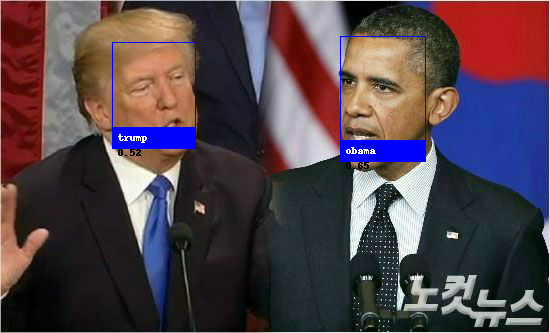

In [8]:
load_iters = 290000
ckpt_name = 'ckpt_' + str(load_iters) + '.pkl'
ckpt_path = os.path.join('weights', ckpt_name)
# if torch.cuda.is_available():
#     net.load_state_dict(torch.load(ckpt_path))
# else:
#     net.load_state_dict(torch.load(ckpt_path,map_location='cpu'))
net.load_state_dict(torch.load(ckpt_path,map_location='cpu'))
net.eval()
torch.no_grad()

f=open("DB.txt")
tmp=f.read()
tmp=tmp.split("\n")
f.close()

known_face_names = []
for i in range(len(tmp)):
    if len(tmp[i])>0:
        data=tmp[i].split()
        known_face_names.append(data[0])
        
        pil_img = Image.open(data[1])        
        bounding_boxes, landmark_points = detect_faces(pil_img)
        image_cropped = crop_image(pil_img, bounding_boxes[0])
        face_feature = net.extract_feature(image_cropped.to(dev))
        
        if i==0:
            known_face_features=face_feature.clone().detach()
        else:
            known_face_features=torch.cat((known_face_features, face_feature))

unknown_image = Image.open('obama_trump.jpg')
#unknown_image = Image.open('obama_rotation.jpg')
#unknown_image = Image.open('ChooJG.jpg')
bounding_boxes, landmarks = detect_faces(unknown_image)

draw = ImageDraw.Draw(unknown_image)

# Loop through each face found in the unknown image
for box in bounding_boxes:
    cropped_image = crop_image(unknown_image, box)
    unknown_face_feature=net.extract_feature(cropped_image)

    name = "Unknown"

    # Or instead, use the known face with the smallest distance to the new face
    distances = face_similarity(known_face_features, unknown_face_feature)
    #print(distances)
    best_match_index = torch.argmax(distances)
    if torch.max(distances)>0.3:
        name = known_face_names[best_match_index]

    left, top, right, bottom, _ = box.astype('int')

    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
    draw.text((left + 6, bottom - text_height + 10), "{0:.2f}".format(torch.max(distances)), fill=(0, 0, 0, 0))

# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(unknown_image)